# TCGA data
1) are there unsupervised methyl cluster types?
2) Can we use this info to improve on the current model caller?
--Run basic clustering analysis on each HMF threshold data set using all regions. Are there clusters? Color plot by metadata . . .
Some random metadata:
https://docs.google.com/presentation/d/1a0C8KGdLWxoBsIWNzwUg5z-xByIMOqi3VtmjbKo78Ms/edit?usp=sharing

3) JSJ's initial work in these notebooks: https://github.com/freenome/jsj_notebooks/blob/master/Featurization/Methylation/Process%20TCGA%20Methylation%20Data%20Into%20Big%20Matrix.ipynb
https://github.com/freenome/jsj_notebooks/blob/master/Featurization/Methylation/Process%20TCGA%20Methylation%20Clean%20CPG%20Islands.ipynb

4) available data:
all methyl:
!gsutil ls gs://all-auxiliary-research-data/tcga_methylation/ | wc -l --> 6385

5) Data paper on COAD and ROAD samples:224 paired tumor normals, 
-- found two main CRC types: hypermutated MSI and MSI-low/CIN
-- found four methyl types - CIMP-hi, CIMP-low, undef clusters 3 adn 4 that are non-hypermutated and differ by location in colon
    -- https://www.nature.com/articles/nature11252 -- original study with small methyl chip
    -- https://www.sciencedirect.com/science/article/pii/S1535610818301144?via%3Dihub -- newer 450K data?

6) Decoding sample barcodes:
-- https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
-- https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables
<img src="tcga_barcode_schematic.png">

7) Methyl chip used?: Illumina Infinium HumanMethylation27 - 450 chip contians 90% of this chip probes

8) source? : 
https://portal.gdc.cancer.gov/projects/TCGA-COAD
https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Methylation_LO_Pipeline/
** original data and metadata found here: https://portal.gdc.cancer.gov/legacy-archive/search/f  (see email from colin)
** metadata files attached to each original methyl chip file here. 

#minfi
https://www.bioconductor.org/help/course-materials/2015/BioC2015/methylation450k.html

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import metrics

from core.gcloud.file import _local_or_cloud_open

In [13]:
# parse file IDS
# 874 COAD_file_names.list
# 218 READ_file_names.list

#what sample type codes are present?
sample_codes = []
participant_codes = []
infiles = []
identifiers = []
with open("./READ_COAD_HM450_file_names.list", "r") as fin:
    for line in fin:
        file = line.split("/")[-1]
        identifier = file.split(".")[5]
        
        # double check for duplicate files
        if identifier in identifiers:
            print(identifier)
            continue
        else:
            identifiers.append(identifier)
            infiles.append(line.strip())
            sample_type = identifier.split("-")[3]
            participant = identifier.split("-")[2]
            assert len(participant) == 4

            sample_codes.append(sample_type)
            participant_codes.append(participant)
        
print(len(sample_codes))
print(Counter(sample_codes))
print(participant_codes[0:4])



TCGA-DM-A0XD-01A-12D-A153-05
404
Counter({'01A': 342, '11A': 43, '01B': 15, '01C': 2, '06A': 1, '02A': 1})
['6620', '6882', '6622', '3731']


In [15]:
len(infiles)

404

In [23]:
# what samples have published metadata?

# patient metadata from 2012 study:
with open("./TCGA_metadata/TCGA_Beadchip27_data/tcga_sample_metadata/summary-Table 1.csv", "r") as fin:
    df_bch27_metadata = pd.read_csv(fin, sep=",")
bch27_patientIDs = [ x.split("-")[2] for x in df_bch27_metadata.patient]

# only 418/1092 files have 2012 patient metadata from bch27
#print(sum([ (pat in bch27_patientIDs) for pat in participant_codes ]))  


# tissue and blood samples: see all_GI tcga supp data files, COAD/READ n = 459 
with open("./TCGA_metadata/TCGA_all_GI_data/tcga_all_gi_metadata.csv", "r") as fin:
    df_bch450_metadata = pd.read_csv(fin)

#print(df_bch450_metadata.shape)
samples =  [ (x in ["COAD", "READ"]) for x in df_bch450_metadata["TCGA Project Code"]]
df_bch450_metadata = df_bch450_metadata[samples]
print(df_bch450_metadata.shape)

# 371 out of 1092 have metadata
print(sum([ (code.split("-")[2] in participant_codes) for code in df_bch450_metadata["TCGA Participant Barcode"]]))

418
(921, 127)
(459, 127)
371


In [5]:
test_data = pd.read_csv("jhu-usc.edu_LUAD.HumanMethylation450.1.lvl-3.TCGA-44-2655-11A-01D-1551-05.gdc_hg38.txt",
                       sep="\t")

In [ ]:
# download the hm450 methyl chip metadata

# details on the Illumina 450 Infinium Chip here: 
# https://support.illumina.com/array/array_kits/infinium_humanmethylation450_beadchip_kit.html
# https://en.wikipedia.org/wiki/Illumina_Methylation_Assay

# https://support.illumina.com/bulletins/2016/05/infinium-methylationk-manifest-column-headings.html
# https://zwdzwd.github.io/InfiniumAnnotation#contact

"""
For a given individual at a given locus, a ratio value of 0 equals to non-methylation of the 
locus (i.e., homozygous unmethylated); a ratio of 1 equals to total methylation (i.e., homozygous methylated); 
and a value of 0.5 means that one copy is methylated and the other is not (i.e., heterozygosity), in the diploid human genome.

Dye bias:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5209853/
Whereas Infinium I uses two probes, both labeled with the same dye (either Cy3 or Cy5), 
to evaluate the methylated and unmethylated states of each target CpG site, Infinium II uses a 
single probe per locus with the competitive binding of methylated (Cy3-green) and unmethylated (Cy5-red) 
alleles evaluated in different color channels.. . .
It was known that the two channels usually perform differently [3] with often overall higher 
intensity values on the red channel than the green channel. 

"""
# A random mask file from JSJ. . . origin unknown.
# info on masks in the chip metadata: https://zwdzwd.github.io/InfiniumAnnotation
!wget http://zwdzwd.io/InfiniumAnnotation/current/hm450/hm450.hg38.manifest.tsv.gz

In [2]:
 hm450_metadata = pd.read_table("hm450.hg38.manifest.tsv.gz")

In [3]:
print(hm450_metadata.columns)

# probeType - either "cg", "ch" or "rs"
#chrm_A, beg_A, flag_A, mapQ_A, cigar_A, NM_A - the mapping info for probe A excluding decoy chromsomes. 
    # mapQ=mapping quality score, 0-60, with 60 being the best.
    # What is the decoy genome: http://www.cureffi.org/2013/02/01/the-decoy-genome/
# Type I probes have only coordinates for 'probe_A' (probe_B = NaN). Type II probes come in pairs with _A and _B
# MASK.general - recommended general purpose masking merged from "MASK.sub30.copy", "MASK.mapping", "MASK.extBase", "MASK.typeINextBaseSwitch" and "MASK.snp5.GMAF1p".
# probe types: {'rs', 'cg', 'ch'} : snp, CpG site, 

# there are 3091 'ch' (control?) probes
print("Control probes")
print(len([x for x in hm450_metadata["probeID"] if x.startswith("ch")]))
print("SNP probes")
print(len([x for x in hm450_metadata["probeID"] if x.startswith("rs")]))
print("Probe types")
print(Counter(hm450_metadata["designType"]))

#filter for autosomal probes only
print(hm450_metadata.shape)
decoys = ['NaN','chrX','chr14_GL000009v2_random','chr22_KI270928v1_alt','chrY',
          'chr19_KI270887v1_alt', 'chr19_KI270938v1_alt', 'chrM', 'chr8_KI270821v1_alt', 'chr22_KI270879v1_alt']
hm450_metadata2 = hm450_metadata[~(hm450_metadata.wDecoy_chrm_A).isin(decoys)]
print("Autosomal probes")
print(hm450_metadata2.shape)

#filter for CpG probes only
print("Remove control and snp probes")
filt = [ x.startswith("cg") for x in hm450_metadata2.probeID]
hm450_metadata3 = hm450_metadata2[filt]
print(hm450_metadata3.shape)

#use the mask.general to filter for 'good' probes, leaves only 63K probes
print("Optional apply mask")
hm450_metadata_good = hm450_metadata3[hm450_metadata3['MASK_general'] == False]
print(hm450_metadata_good.shape)


Index(['CpG_chrm', 'CpG_beg', 'CpG_end', 'probe_strand', 'probeID',
       'address_A', 'address_B', 'channel', 'designType', 'nextBase',
       'nextBaseRef', 'probeType', 'orientation', 'probeCpGcnt', 'context35',
       'probeBeg', 'probeEnd', 'ProbeSeq_A', 'ProbeSeq_B', 'gene', 'gene_HGNC',
       'chrm_A', 'beg_A', 'flag_A', 'mapQ_A', 'cigar_A', 'NM_A', 'chrm_B',
       'beg_B', 'flag_B', 'mapQ_B', 'cigar_B', 'NM_B', 'wDecoy_chrm_A',
       'wDecoy_beg_A', 'wDecoy_flag_A', 'wDecoy_mapQ_A', 'wDecoy_cigar_A',
       'wDecoy_NM_A', 'wDecoy_chrm_B', 'wDecoy_beg_B', 'wDecoy_flag_B',
       'wDecoy_mapQ_B', 'wDecoy_cigar_B', 'wDecoy_NM_B', 'posMatch',
       'MASK_mapping', 'MASK_typeINextBaseSwitch', 'MASK_rmsk15',
       'MASK_sub40_copy', 'MASK_sub35_copy', 'MASK_sub30_copy',
       'MASK_sub25_copy', 'MASK_snp5_common', 'MASK_snp5_GMAF1p',
       'MASK_extBase', 'MASK_general'],
      dtype='object')
Control probes
3091
SNP probes
65
Probe types
Counter({'II': 350076, 'I': 135501})


# minimum for initial analysis
-- remove probes that are not "cg"
-- remove all X/Y probes
-- remove NaN beta val probes
-- plot beta values for type I vs type II probes and see if skewed
-- plot beta distrib (violin) by sample to see if sample level norm is needed (for intensity)

Ah ha!!!
LEVEL 3: Derived summary measures (beta values: M/(M+U) for each interrogated locus) with annotations for gene symbol, chromosome (UCSC hg19, Feb 2009), and CpG/CpH coordinate (UCSC hg19, Feb 2009). Probes having a common SNP (common SNP is a SNP with Minor Allele Frequency > 1% as defined by the UCSC snp135common track) within 10bp of the interrogated CpG site or having 15bp from the interrogated CpG site overlap with a REPEAT element (as defined by RepeatMasker and Tandem Repeat Finder Masks based on UCSC hg19, Feb 2009) are masked as NA across all samples, and probes with a non-detection probability (P-value) greater than 0.05 in a given sample are masked as NA on that chip. Probes that are mapped to multiple sites on hg19 are annotated as NA for chromosome and 0 for CpG/CpH coordinate


In [6]:
test_data.head()

,Composite Element REF,Beta_value,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type
0,cg00000029,0.205835,chr16,53434200,53434201,RBL2;RBL2;RBL2,protein_coding;protein_coding;protein_coding,ENST00000262133.9;ENST00000544405.5;ENST000005...,-221;-1420;222,CGI:chr16:53434489-53435297,N_Shore
1,cg00000108,NaN,chr3,37417715,37417716,C3orf35;C3orf35;C3orf35;C3orf35;C3orf35;C3orf3...,lincRNA;lincRNA;lincRNA;lincRNA;lincRNA;lincRN...,ENST00000328376.8;ENST00000332506.6;ENST000004...,18552;18552;6505;31445;18143;447;18552;18552,CGI:chr3:37451927-37453047,.
2,cg00000109,NaN,chr3,172198247,172198248,FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B,protein_coding;protein_coding;protein_coding;p...,ENST00000336824.7;ENST00000415807.5;ENST000004...,157692;158618;151333;71272;158587;71273,CGI:chr3:172039703-172040934,.
3,cg00000165,0.268277,chr1,90729117,90729118,.,.,.,.,CGI:chr1:90724932-90727247,S_Shore
4,cg00000236,0.849932,chr8,42405776,42405777,VDAC3,protein_coding,ENST00000022615.7,13872,CGI:chr8:42410918-42411241,.


In [17]:
# Roughly filter out probes we don't want from test dataset
print(test_data.shape)

probes = [ x.startswith("cg") for x in test_data["Composite Element REF"]]
test_data_filt = test_data[probes]
print(test_data_filt.shape)

probes = [ x not in ["chrX","chrY"] for x in test_data_filt["Chromosome"]]
test_data_filt = test_data_filt[probes]
print(test_data_filt.shape)

#probes = [ ~np.isnan(x) for x in test_data_filt["Beta_value"]]
#test_data_filt = test_data_filt[probes]
#print(test_data_filt.shape)

probes = [ x!="*" for x in test_data_filt["Chromosome"]]  # I think these are probes with ambig. mapping
test_data_filt = test_data_filt[probes]
print(test_data_filt.shape)

print(set(test_data_filt["Chromosome"]))
probes_to_keep = test_data_filt["Composite Element REF"]
#probes_to_keep_bool = [x in set(list(probes_to_keep)) for x in test_data["Composite Element REF"]] #this takes a very long time



(485577, 11)
(482421, 11)
(471000, 11)
(465923, 11)
{'chr14', 'chr6', 'chr11', 'chr4', 'chr12', 'chr5', 'chr13', 'chr3', 'chr16', 'chr18', 'chr2', 'chr19', 'chr10', 'chr7', 'chr8', 'chr9', 'chr22', 'chr1', 'chr21', 'chr17', 'chr15', 'chr20'}


In [9]:
# test_data.index = test_data.index.astype(str)
# probes_to_keep_bool = []
# for prb in test_data.index:
#     if prb.startswith("cg") and (test_data.at[prb, "Chromosome"] not in ["chrX","chrY"]) and (test_data.at[prb, "Chromosome"] != "*"):
#         probes_to_keep_bool.append(True)
#     else:
#         probes_to_keep_bool.append(False)
        
# print(len(test_data.index))
# print(len(probes_to_keep_bool))
# print(probes_to_keep_bool[0:10])
# print(sum([1 if x else 0 for x in probes_to_keep_bool]))

485577
485577
[False, False, False, False, False, False, False, False, False, False]
0


In [10]:
# gather and save probe metadata
#print(test_data_filt.head())
#print(set(test_data_filt.Feature_Type))  #{'N_Shelf', '.', 'N_Shore', 'S_Shelf', 'S_Shore', 'Island'}

df_keep_probes_metadata = test_data_filt.drop("Beta_value", axis=1)
df_keep_probes_metadata = df_keep_probes_metadata.set_index("Composite Element REF")

pickle.dump(df_keep_probes_metadata, open("./df_keep_probes_metadata.pkl", "wb"))



In [72]:
# pickle.dump(probes_to_keep_bool, open("./probes_to_keep_bool.pkl", "wb"))
# #print(hm450_metadata.head())
# #print(hm450_metadata.columns)

{'II', 'I'}


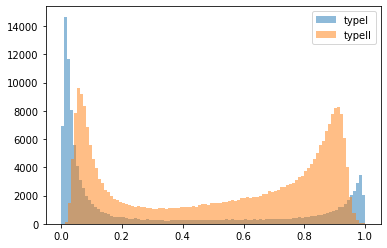

In [37]:
# see if type I and type II probes are different
#print(hm450_metadata.head())
#print(hm450_metadata.shape)
probe_meta = hm450_metadata[["probeID","designType"]]
probe_meta.index = probe_meta["probeID"]
#probe_meta.head()

test_data_filt.index = test_data_filt["Composite Element REF"]
test_data_prb = test_data_filt.join(probe_meta, how="left")

test_data_prb.head()
print(set(test_data_prb.designType)) # no NaNs for type

plt.figure()
typeI = test_data_prb[test_data_prb["designType"] == "I"]["Beta_value"]
plt.hist(typeI, alpha=0.5, bins=100, label="typeI")
typeII = test_data_prb[test_data_prb["designType"] == "II"]["Beta_value"]
_, _, h = plt.hist(typeII, alpha=0.5, bins=100, label="typeII")
plt.legend()


In [19]:
probes_to_keep_bool = pickle.load(open("./probes_to_keep_bool.pkl","rb")) # a bool vector
sum(probes_to_keep_bool)

465923

<img src="tcga_barcode_schematic.png">

In [20]:
# Read all READ and COAD HM450 methylation data into a single data structure
    # skip .parcel files
    # skip HM27 files

sample_code_to_class = {"11":"Normal", 
                        "01":"CRC",
                        "02":"CRC",
                        "06":"CRC"}

probes_to_keep_bool = pickle.load(open("./probes_to_keep_bool.pkl","rb")) # a bool vector

sample_metadata = []
data_dfs = []
bad_files = []
i=0
for path in infiles:
    i += 1
    # jhu-usc.edu_LUAD.HumanMethylation450.1.lvl-3.TCGA-44-2655-11A-01D-1551-05.gdc_hg38.txt
    # parse metadata
    try:
        study = path.split("/")[-1].split(".")[1].split("_")[-1]
        #assert study in ["COAD", "READ"], f"error: study: {study}"

        identifier = path.split("/")[-1].split(".")[-3]
        assert identifier.split("-")[0] == "TCGA"

        tissue_source_site = identifier.split("-")[1]
        assert len(tissue_source_site)==2, f"error: TSS: {tissue_source_site}"

        participant = identifier.split("-")[2]
        assert len(participant)==4, f"error: participant: {participant}"

        sample = identifier.split("-")[3][0:-1]
        assert len(sample)==2, f"error: sample: {sample}"
        #sample_type = sample_code_to_class[sample]

        plate = identifier.split("-")[5]
        assert len(plate)==4, f"error: plate: {plate}"

        center = identifier.split("-")[6]
        assert len(center)==2, f"error: center: {center}"

        sample_metadata.append({"identifier":identifier,
                           "tss":tissue_source_site,
                           "participant":participant,
                           "sample_type":sample_type,
                           "plate":plate,
                           "center":center,
                           "study":study})
        #print(sample_metadata)
    except AssertionError:
        bad_files.append(path)
        print(f"weird metadata: skipping {path}")
        continue
    
    # read in data file
    df_data = pd.read_csv(_local_or_cloud_open(path), sep="\t")
    
    try:
        assert df_data.shape == (485577, 11)
        assert list(df_data["Composite Element REF"][0:2]) == ["cg00000029", "cg00000108"] #check the probe order
        assert list(df_data["Composite Element REF"][-2:]) == ["rs966367", "rs9839873"]
    except:
        bad_files.append(path)
        print(f"wrong probe order: skipping {path}")
        continue
    
    df_data = df_data.set_index("Composite Element REF")
    df_data = df_data.loc[probes_to_keep_bool, ["Beta_value"]]
    df_data.columns = [identifier]
    data_dfs.append(df_data)
    
    print(f"{i} of {len(infiles)} : {identifier} complete.")

#print(pd.DataFrame.from_dict(sample_metadata).head())
#print(len(sample_metadata))
#print(len(data_dfs))
df_all = pd.concat(data_dfs, axis=1)
#print(df_all.head())
df_all.head()
print(df_all.shape)

pickle.dump(df_all, open("./df_coad_read_raw_beta_vals.pkl", "wb"))  #1.4 GB
pickle.dump(sample_metadata, open("./coad_read_sample_metadata.pkl", "wb"))

1 of 404 : TCGA-CI-6620-01A-11D-1828-05 complete.
2 of 404 : TCGA-EI-6882-01A-11D-1926-05 complete.
3 of 404 : TCGA-CI-6622-01A-11D-1828-05 complete.
4 of 404 : TCGA-AG-3731-11A-01D-1734-05 complete.
5 of 404 : TCGA-EI-6509-01A-11D-1734-05 complete.
6 of 404 : TCGA-DY-A1H8-01A-21D-A153-05 complete.
7 of 404 : TCGA-DC-5869-01A-01D-1658-05 complete.
8 of 404 : TCGA-AF-2687-01A-02D-1734-05 complete.
9 of 404 : TCGA-AF-4110-01A-02D-1734-05 complete.
10 of 404 : TCGA-CI-6624-01C-11D-1828-05 complete.
11 of 404 : TCGA-EI-6885-01A-11D-1926-05 complete.
12 of 404 : TCGA-EI-7004-01A-11D-1926-05 complete.
13 of 404 : TCGA-F5-6863-01A-11D-1926-05 complete.
14 of 404 : TCGA-F5-6814-01A-31D-1926-05 complete.
15 of 404 : TCGA-CI-6621-01A-11D-1828-05 complete.
16 of 404 : TCGA-EI-7002-01A-11D-1926-05 complete.
17 of 404 : TCGA-EI-6512-01A-11D-1734-05 complete.
18 of 404 : TCGA-CI-6619-01B-11D-1828-05 complete.


KeyboardInterrupt: 

## Normalize and cluster TCGA dataset

In [2]:
# load the raw data set and metadata
df_all = pickle.load(open("./df_coad_read_raw_beta_vals.pkl", "rb"))
print(df_all.shape)

sample_metadata = pickle.load(open("./coad_read_sample_metadata.pkl", "rb"))
print(len(sample_metadata))

(465923, 404)
404


In [3]:
# load probe metadata
df_probe_metadata = pickle.load(open("./df_keep_probes_metadata.pkl", "rb"))
print(df_probe_metadata.shape)
print(df_probe_metadata.head())

(465923, 13)
                      Chromosome      Start        End  \
Composite Element REF                                    
cg00000029                 chr16   53434200   53434201   
cg00000108                  chr3   37417715   37417716   
cg00000109                  chr3  172198247  172198248   
cg00000165                  chr1   90729117   90729118   
cg00000236                  chr8   42405776   42405777   

                                                             Gene_Symbol  \
Composite Element REF                                                      
cg00000029                                                RBL2;RBL2;RBL2   
cg00000108             C3orf35;C3orf35;C3orf35;C3orf35;C3orf35;C3orf3...   
cg00000109                     FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B   
cg00000165                                                             .   
cg00000236                                                         VDAC3   

                                               

In [4]:
# Read in panel beds

from collections import defaultdict
from core.gcloud.file import opener

# create an empty chrom dict of intervals and fill in with freenome_v1_panel regions annotated as "True"

v1_regions = defaultdict(list)

v3_regions = defaultdict(list)

# all 16K v1 panel regions
v1_16K_regions = defaultdict(list)
with open("../methyl_panel_v1_target_twist.bed", "r") as fin:
    bed = pd.read_csv(fin, sep="\t", header=None)
    #print(bed.head())
    bed = bed.iloc[:,0:3]
    bed.columns = ['chrom', 'start', 'stop']
    for _, row in bed.iterrows():
        reg_name = str(row.chrom) + "_"+ str(row.start) + "_"+ str(row.stop)
        v1_16K_regions[row['chrom']].append((row['start'],row['stop'], reg_name))
    
# 434 Regions selected by early modeling and by lit search
with opener('gs://reference-datafiles/beds/freenome_v1_panel_manual_and_automated_per_region_hmf_definition_20190823.bed', 'r') as handle:
    expected_bed = pd.read_csv(handle, sep="\t", header=None)
    expected_bed.columns = ['chrom', 'start', 'stop']
    for _, row in expected_bed.iterrows():
        reg_name = str(row.chrom) + "_"+ str(row.start) + "_"+ str(row.stop)
        v1_regions[row['chrom']].append((row['start'],row['stop'], reg_name))

# 3200 Regions selected as high CpG for v3 enriched capture panel
# create an empty chrom dict of intervals and fill in with freenome_v3_panel regions annotated as "True"
with opener('gs://reference-datafiles/panel_v3/v3_panel_repeat_and_cpg_filtered.bed', 'r') as handle:
    v3_bed = pd.read_csv(handle, sep="\t", header=None, comment="#").iloc[:, :3]
    v3_bed.columns = ['chrom', 'start', 'stop']
    for _, row in v3_bed.iterrows():
        reg_name = "X"
        v3_regions[row['chrom']].append((row['start'],row['stop'], reg_name))

In [14]:
# annotate probes that overlap all 16K v1 regions. Takes almost 1 hour. 
print(df_probe_metadata.shape)
df_probe_metadata["in_v1_panel"] = False
df_probe_metadata["v1_region"] = "NA"
i=0
for prb, row in df_probe_metadata.iterrows():
    i+=1
    if i % 10000 == 0:
        print(f"probes processed {i}")
        #break
    for int_start, int_stop, reg_name in v1_16K_regions[row.Chromosome]:
        if int_start < int(row.Start) <= int_stop + 1:  # bed file is 0-based, chip coord is 1-based, I think
            #print("Yay!")
            df_probe_metadata.loc[prb, ["in_v1_panel"]] = True
            df_probe_metadata.loc[prb, ["v1_region"]] = reg_name
            continue

# write annotation info to outfile
pickle.dump(df_probe_metadata, open("./df_keep_probes_metadata.pkl", "wb"))

(465923, 13)
probes processed 10000
probes processed 20000
probes processed 30000
probes processed 40000
probes processed 50000
probes processed 60000
probes processed 70000
probes processed 80000
probes processed 90000
probes processed 100000
probes processed 110000
probes processed 120000
probes processed 130000
probes processed 140000
probes processed 150000
probes processed 160000
probes processed 170000
probes processed 180000
probes processed 190000
probes processed 200000
probes processed 210000
probes processed 220000
probes processed 230000
probes processed 240000
probes processed 250000
probes processed 260000
probes processed 270000
probes processed 280000
probes processed 290000
probes processed 300000
probes processed 310000
probes processed 320000
probes processed 330000
probes processed 340000
probes processed 350000
probes processed 360000
probes processed 370000
probes processed 380000
probes processed 390000
probes processed 400000
probes processed 410000
probes proce

In [ ]:
"""
# annotate probes that overlap 434 clean regions 
df_keep_probes_metadata["in_v1_panel"] = False
df_keep_probes_metadata["v1_region"] = "NA"
i=0
for prb, row in df_keep_probes_metadata.iterrows():
    i+=1
    if i % 10000 == 0:
        print(f"probes processed {i}")
        #break
    for int_start, int_stop, reg_name in v1_regions[row.Chromosome]:
        if int_start < int(row.Start) <= int_stop + 1:  # bed file is 0-based, chip coord is 1-based, I think
            #print("Yay!")
            df_keep_probes_metadata.loc[prb, ["in_v1_panel"]] = True
            df_keep_probes_metadata.loc[prb, ["v1_region"]] = reg_name

pickle.dump(df_keep_probes_metadata, open("./df_keep_probes_metadata.pkl", "wb"))
"""

In [ ]:
# annotate probes that overlap 3200 enrichment (v3) regions 
"""
df_keep_probes_metadata["in_v3_panel"] = False
i=0
for prb, row in df_keep_probes_metadata.iterrows():
    i+=1
    if i % 10000 == 0:
        print(f"probes processed {i}")
        #break
    for int_start, int_stop in v3_regions[row.Chromosome]:
        if int_start < int(row.Start) <= int_stop + 1:  # bed file is 0-based, chip coord is 1-based, I think
            #print("Yay!")
            df_keep_probes_metadata.loc[prb, ["in_v3_panel"]] = True

pickle.dump(df_keep_probes_metadata, open("./df_keep_probes_metadata.pkl", "wb"))
"""

In [5]:
print(np.sum(df_probe_metadata.in_v1_panel)) # 2047 probes in v1_subset, 25688 in v1 all
print(np.sum(df_probe_metadata.in_v3_panel)) # 29321 probes
print(sample_metadata[0])

2047
29321
{'identifier': 'TCGA-CI-6620-01A-11D-1828-05', 'tss': 'CI', 'participant': '6620', 'sample_type': 'CRC', 'plate': '1828', 'center': '05', 'study': 'READ'}


(25688, 361)
(23831, 361)
3104
0
                      Chromosome      Start        End  \
Composite Element REF                                    
cg00000029                 chr16   53434200   53434201   
cg00001687                 chr16   89695253   89695254   
cg00002593                  chr1    1333413    1333414   
cg00002719                  chr1  169427468  169427469   
cg00002810                  chr1   57423035   57423036   

                                                           Gene_Symbol  \
Composite Element REF                                                    
cg00000029                                              RBL2;RBL2;RBL2   
cg00001687             CDK10;CDK10;CDK10;CDK10;CDK10;CDK10;CDK10;CDK10   
cg00002593                                                      TAS1R3   
cg00002719                     CCDC181;CCDC181;CCDC181;CCDC181;CCDC181   
cg00002810                                              DAB1;DAB1;DAB1   

                                         

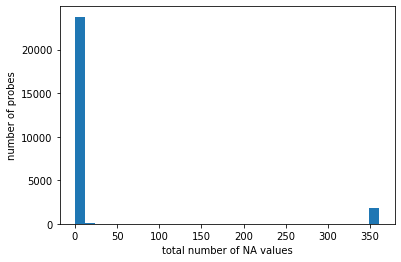

In [44]:
# Filter out probes with a high rate of NA in CRC
df_all_v1 = df_all[df_probe_metadata["in_v1_panel"]]  # probes x samples

samples = [d["sample_type"]=="CRC" for d in sample_metadata]
df_all_v1_crc = df_all_v1.loc[:,samples]
print(df_all_v1_crc.shape) #(25688, 361)

na_sums = df_all_v1_crc.apply(lambda x: np.sum(x.isnull()), axis=1)
#print(na_sums[0:10])
plt.hist(na_sums, bins=30)
plt.xlabel("total number of NA values")
plt.ylabel("number of probes")

#for row in df_all_v1_crc.index:
#    if df_all_v1_crc.loc[row,:].isnull().sum() > 100:
#        print(df_all_v1_crc.loc[row,:])
#        break

def pct_na(row):
    return np.sum(row.isnull())/float(len(row))

pct_nas = df_all_v1_crc.apply(lambda x: pct_na(x), axis=1)
#print(len(pct_nas))
keep_prbs = [x<0.1 for x in pct_nas]
df_all_v1_crc = df_all_v1_crc[keep_prbs] # remove 1857 probes
print(df_all_v1_crc.shape)

# replace remaining na s with probe median
print(df_all_v1_crc.isnull().sum().sum())
df_all_v1_crc = df_all_v1_crc.T
df_all_v1_crc = df_all_v1_crc.fillna(df_all_v1_crc.median(axis=0))
print(df_all_v1_crc.isnull().sum().sum())

filt_probe_metadata = df_probe_metadata[df_probe_metadata["in_v1_panel"]] #2047
print(filt_probe_metadata.head())
keep_probes = [(prb in df_all_v1_crc.index) for prb in filt_probe_metadata.index]
filt_probe_metadata = filt_probe_metadata[keep_probes]
print(filt_probe_metadata.shape)

In [3]:
# load data
df_all_v1_crc = pd.read_csv(open("./df_tcga_16k_v1_probes_crc.csv","r"))
df_all_v1_crc = df_all_v1_crc.set_index("Unnamed: 0")
df_all_v1_crc.head()

,cg00000029,cg00001687,cg00002593,cg00002719,cg00002810,cg00006884,cg00008036,cg00008446,cg00008493,cg00009292,...,cg27651218,cg27651229,cg27651238,cg27651243,cg27653384,cg27657439,cg27657926,cg27658304,cg27662483,cg27665925
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-CI-6620-01A-11D-1828-05,0.163845,0.884531,0.592402,0.109490,0.604347,0.053263,0.421609,0.222524,0.963142,0.661379,...,0.873086,0.473340,0.885595,0.493377,0.076676,0.636505,0.851928,0.038886,0.087881,0.019664
TCGA-EI-6882-01A-11D-1926-05,0.127087,0.985613,0.527908,0.886338,0.700419,0.047278,0.697084,0.454086,0.952586,0.739752,...,0.926234,0.487901,0.916632,0.677710,0.090908,0.385132,0.892452,0.039739,0.596854,0.016425
TCGA-CI-6622-01A-11D-1828-05,0.125635,0.987054,0.594479,0.390514,0.680678,0.046554,0.445186,0.295177,0.944107,0.622640,...,0.933658,0.545772,0.902612,0.106428,0.078004,0.710241,0.912009,0.041552,0.427952,0.016680
TCGA-EI-6509-01A-11D-1734-05,0.066121,0.569732,0.323395,0.385721,0.425411,0.027911,0.039823,0.241635,0.947320,0.544278,...,0.879058,0.050760,0.924023,0.031031,0.062430,0.731865,0.901638,0.015516,0.479631,0.010720
TCGA-DY-A1H8-01A-21D-A153-05,0.133101,0.983788,0.913261,0.933726,0.776252,0.050356,0.468839,0.641507,0.910400,0.863367,...,0.939269,0.100452,0.963730,0.048683,0.060119,0.561429,0.917669,0.035812,0.462427,0.016362


In [46]:
# write probe data for 16K regions and sample labels
#print(df_all_v1_crc.head())
df_all_v1_crc.to_csv("./df_tcga_16k_v1_probes_crc.csv")
filt_probe_metadata.to_csv( "./df_tcga_16k_v1_probe_metadata.csv")

23831
cg03616722    0.354698
cg18222083    0.350037
cg11738485    0.345123
cg17300544    0.341781
dtype: float64


(array([172., 152., 113.,  99.,  90.,  86.,  71.,  66.,  33.,  31.,  26.,
         21.,  10.,  11.,   7.,   5.,   3.,   2.,   1.,   1.]),
 array([0.26522194, 0.26969577, 0.27416959, 0.27864341, 0.28311723,
        0.28759105, 0.29206487, 0.29653869, 0.30101251, 0.30548633,
        0.30996015, 0.31443397, 0.3189078 , 0.32338162, 0.32785544,
        0.33232926, 0.33680308, 0.3412769 , 0.34575072, 0.35022454,
        0.35469836]),
 <a list of 20 Patch objects>)

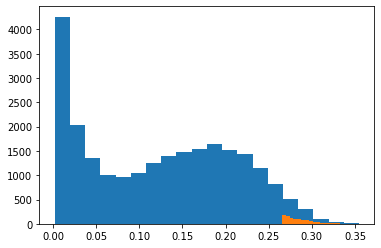

In [4]:
# choose the 1000 most variable probes
prb_sds = pd.Series(df_all_v1_crc.apply(np.std, axis=0), index=df_all_v1_crc.columns)
print(len(prb_sds))
top_prbs = prb_sds.sort_values(ascending=False)[0:1000]
print(top_prbs[0:4])

df_top_v1_prb_crc = df_all_v1_crc.reindex(top_prbs.index, axis=1)
df_top_v1_prb_crc.head()

plt.hist(df_all_v1_crc.apply(np.std, axis=0), bins=20)
plt.hist(df_top_v1_prb_crc.apply(np.std, axis=0), bins=20)

#df_top_v1_prb_crc.to_csv("./df_tcga_top1K_v1_probes_crc.csv", index=True)

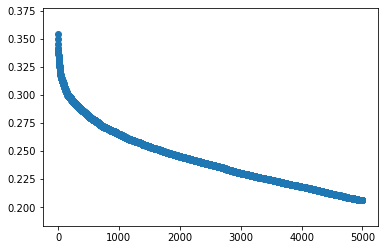

In [24]:
vals = prb_sds.sort_values(ascending=False)[0:5000]
plt.scatter(x=range(len(vals)),y=list(vals))

In [14]:
# impose binary mask and write probe data for 16K regions
#df_all_v1_mask = df_all_v1_crc.where(df_all_v1_crc < 0.2, 1)
#df_all_v1_mask = df_all_v1_mask.where(df_all_v1_mask >= 0.2, 0)
#df_all_v1_mask.to_csv( "./df_tcga_16k_v1_probes_crc_pt2mask.csv")

In [9]:
# impose binary mask and write probe data for 1K top probes
df_top_v1_prb_crc_mask = df_top_v1_prb_crc.where(df_top_v1_prb_crc  < 0.2, 1) # keep vals < 0.2, all else 1
df_top_v1_prb_crc_mask = df_top_v1_prb_crc_mask.where(df_top_v1_prb_crc_mask == 1, 0)
df_top_v1_prb_crc_mask.to_csv( "./df_tcga_top1k_v1_probes_crc_pt2mask.csv")


In [56]:
# K-means clustering
def test_opt_num_clust_kmeans(df, labels, sample_metadata, K, subset=None, fig_pfx=None):
    assert K, "specify optimal number of clusters"
    if subset:
        print("Subsetting data . . .")
        df = df.loc[subset,:]
        print(df.shape)
        labels = np.array(labels)[subset]
        sample_metadata = sample_metadata[subset]
    
    print(df.shape)
    assert df.shape[0] == len(labels)
    assert pd.DataFrame(df).isnull().sum().sum() == 0, "NAs present"
    
    k_vals = [1,2,3,4,5,6,7,8,10,12,16,18]
    scores = []
    for k in k_vals:
        clust = KMeans(n_clusters=k, random_state=0)
        clust.fit(df)
        #score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        score = clust.inertia_  # this is the total within cluster summs of squares at k=k
        scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    plt.figure()
    plt.scatter(k_vals, scores, lw=2)
    plt.plot(k_vals, scores, lw=2)
    plt.xlim((0,8.5))
    plt.hlines(scores[K-1],linestyles='dashed', xmin=0, xmax=9)
    plt.title("total within-cluster variation")
    plt.xlabel("number of clusters")
    plt.ylabel("total sums of squares")
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_scores.png")
    
    # make heatmap labeled by clusters at k=3
    plt.figure()

    #color rows by label
    cols = sns.color_palette("Paired")
    d_row_colors = {"Normal_COAD": cols[0], "CRC_COAD":cols[4], "Normal_READ":cols[1], "CRC_READ":cols[5]}
    label_colors = [d_row_colors[lab] for lab in labels]
    label_colors = pd.Series(label_colors, index=df.index)

    # color rows by cluster membership
    cols = sns.color_palette("Set2")
    clust = KMeans(n_clusters=K, random_state=0)
    clust.fit(df)
    clust_colors = pd.Series([cols[c] for c in clust.labels_], index=df.index)
    
    # color rows by age
    #cmap = plt.cm.Greens
    #ages = [d["patient"]["age"] for d in sample_metadata]
    #norm = matplotlib.colors.Normalize(vmin=min(ages), vmax=max(ages), clip=True)
    #mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    #age_colors = pd.Series(list(mapper.to_rgba(ages)), index=mat.index)  # FIX BUG HERE
    
    #sort dfvrows by cluster membership
    clust_lab_sorted = pd.Series(clust.labels_, index=df.index).sort_values()
    df_row_sort = df.reindex(clust_lab_sorted.index, axis=0)
    
    #sort row color labels by cluster membership
    label_colors = label_colors.reindex(clust_lab_sorted.index)
    clust_colors = clust_colors.reindex(clust_lab_sorted.index)
    #age_colors = age_colors.reindex(clust_lab_sorted.index)
    
    #sort df cols from low to high
    #marker_sums = mat.apply(np.sum, axis=0)
    #mat_col_sort = mat_row_sort.reindex(marker_sums.sort_values().index, axis=1)

    #sns.heatmap(mat_col_sort, yticklabels=False, xticklabels=False)
    cg = sns.clustermap(df_row_sort, 
                        row_cluster=False, #col_cluster=False,
                        row_colors=[label_colors, 
                                    clust_colors],
                        yticklabels=False, 
                        xticklabels=False,
                        figsize=(20,20))
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_heatmap.png")

(404, 1851)


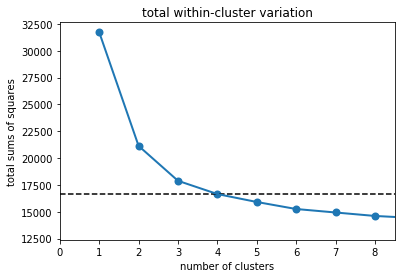

<Figure size 432x288 with 0 Axes>

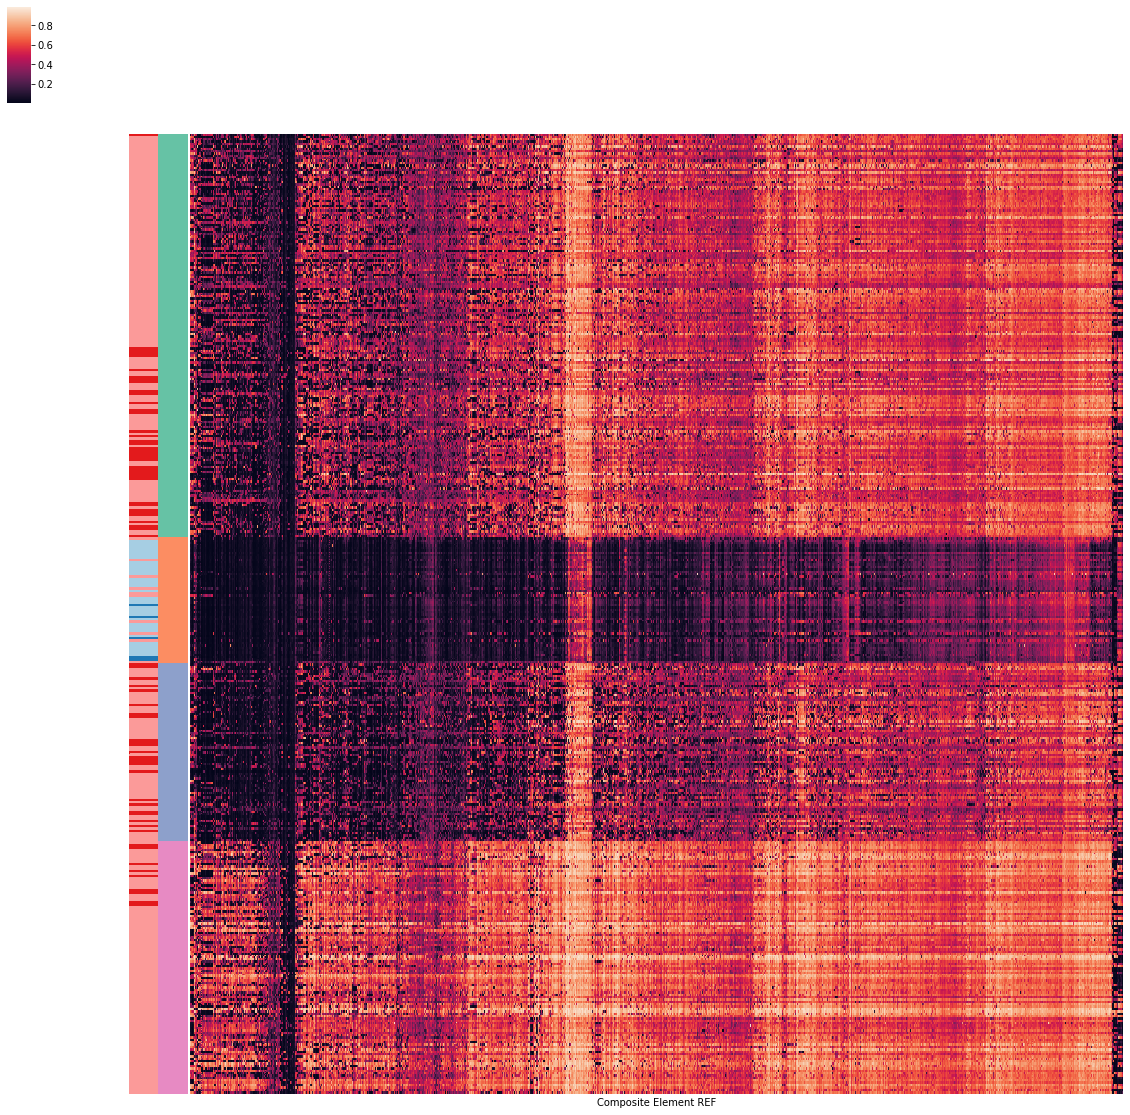

In [58]:
labels = [(d["sample_type"]+"_"+d["study"]) for d in sample_metadata] 
test_opt_num_clust_kmeans(df_all_v1, labels, sample_metadata, 4, subset=None, fig_pfx="tcga_kmeans_v1_430reg_probes")

Subsetting data . . .
(361, 1851)
(361, 1851)


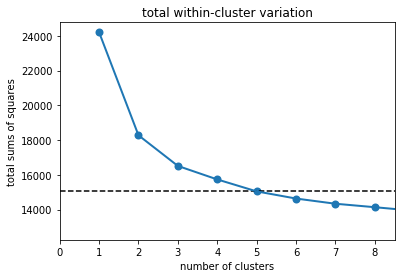

<Figure size 432x288 with 0 Axes>

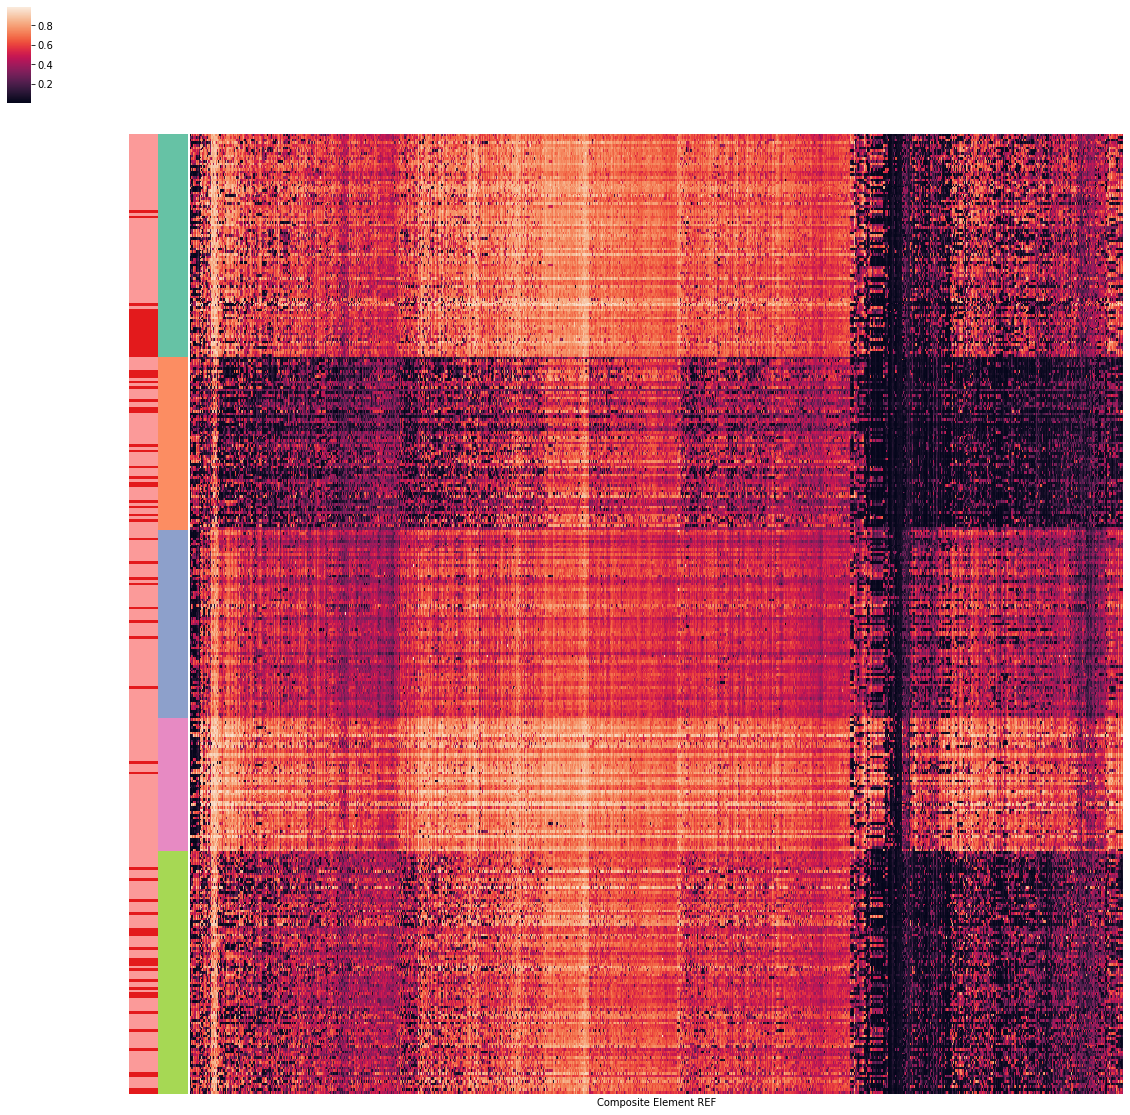

In [62]:
labels = [(d["sample_type"]+"_"+d["study"]) for d in sample_metadata]
crc_samples = ["CRC" in lbl for lbl in labels]
test_opt_num_clust_kmeans(df_all_v1, labels, sample_metadata, 5, subset=crc_samples, fig_pfx="tcga_kmeans_v1_430reg_probes_crc_only")

# Group probes by v1 panel region and recluster

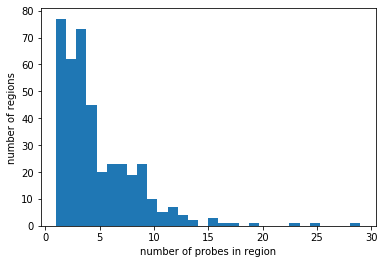

In [262]:
# Calc how many probes per region on average
probe_counts = []
for region in set(filt_probe_metadata["v1_region"]):
    count = np.sum([x==region for x in filt_probe_metadata["v1_region"]])
    probe_counts.append(count)

plt.hist(probe_counts, bins=30)
plt.xlabel("number of probes in region")
plt.ylabel("number of regions")
plt.savefig("./probes_per_434_region_hist.png")

In [264]:
# convert probe data to region methylation levels

sample_data_dicts = []
i=0
for sample in df_all_v1.columns:
    i+=1
    sample_data = {}
    for region in set(filt_probe_metadata["v1_region"]):
        probes = [x==region for x in filt_probe_metadata["v1_region"]]
        if len(probes) < 5:  # skip regions with fewer than 5 probes
            continue
        else:
            reg_probe_betas = list(df_all_v1.loc[probes, sample])
            #print(reg_probe_betas)
            try:
                meth = [ 1 if x >= 0.3 else 0 for x in reg_probe_betas]  # hard cut off for beta value
            except:
                print(sample)
                print(region)
            pct_meth = np.sum(meth)/len(meth)  # raw percent probes methylated
            sample_data[region] = pct_meth

    sample_data_dicts.append(sample_data)
    if i % 20 == 0:
        print(len(sample_data_dicts))

df_v1_region_pct_meth = pd.DataFrame(sample_data_dicts)
df_v1_region_pct_meth.index = df_all_v1.columns
print(len(set(filt_probe_metadata["v1_region"])))
print(df_v1_region_pct_meth.shape)
df_v1_region_pct_meth.head()

pickle.dump(df_v1_region_pct_meth, open("./df_v1_region_pct_meth.pkl", "wb")) # 404 samples by 402 regions

(1851, 404)
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
402
(404, 402)


In [ ]:
# clustering on regionalized probe tissue data
method="ward"

labels = [(d["sample_type"]+"_"+d["study"]) for d in sample_metadata]

cols = sns.color_palette("Paired")
d_row_colors = {"Normal_COAD": cols[0], "CRC_COAD":cols[4], "Normal_READ":cols[1], "CRC_READ":cols[5]}

row_colors = [d_row_colors[lab] for lab in labels]
cg = sns.clustermap(df_v1_region_pct_meth, figsize=(20,50), 
                    row_colors=row_colors, xticklabels=[], 
                    yticklabels=[], method=method)
cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram
plt.savefig(f"./tcga_all_v1_reg_pct_meth_heatmap_{method}.png")

#plot one heatmap per tumor location group
for study in ["READ", "COAD"]:
    samples = [ std == study for std in [d["study"] for d in sample_metadata]]
    print(np.sum(samples))
    labels_ = np.array(labels)[samples]
    row_colors = [d_row_colors[lab] for lab in labels_]
    cg = sns.clustermap(df_v1_region_pct_meth[samples], figsize=(20,40), 
                        row_colors=row_colors, xticklabels=[], yticklabels=[],
                        method=method)
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram
    plt.savefig(f"./tcga_{study}_v1_reg_pct_meth_heatmap_{method}.png")


In [329]:
# find optimal number of hierarchical clusters
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

def test_opt_num_clust(mat, figname):
    k_vals = [2,3,4,5,6,7,8,9,10,11,12]
    scores = []
    for k in k_vals:
        clust = AgglomerativeClustering(n_clusters=k, linkage="ward")
        clust.fit(mat)
        #score = metrics.calinski_harabasz_score(df_v1_region_pct_meth_crc_only, clust.labels_)
        score = metrics.calinski_harabasz_score(mat, clust.labels_)
        #score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    plt.scatter(k_vals, scores, lw=2)
    plt.plot(k_vals, scores, lw=2)
    plt.xlabel("number of clusters")
    plt.ylabel("clustering score")
    plt.savefig(f"./{figname}")

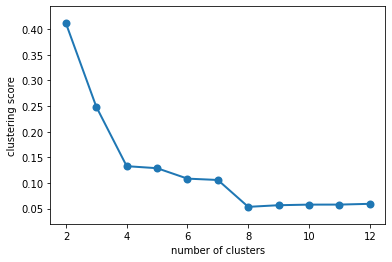

In [327]:
test_opt_num_clust(df_v1_region_pct_meth, "clust_scores_siloh_v1_regions_all.png")

Composite Element REF         cg00004257  cg00017489  cg00020052  cg00024472  \
TCGA-CI-6620-01A-11D-1828-05    0.136142    0.773916    0.635640    0.013193   
TCGA-EI-6882-01A-11D-1926-05    0.444545    0.887144    0.746583    0.013985   
TCGA-CI-6622-01A-11D-1828-05    0.764589    0.829549    0.685591    0.584743   
TCGA-AG-3731-11A-01D-1734-05    0.207505    0.409375    0.136032    0.014129   
TCGA-EI-6509-01A-11D-1734-05    0.061193    0.785332    0.419553    0.011144   

Composite Element REF         cg00076307  cg00081574  cg00082235  cg00082664  \
TCGA-CI-6620-01A-11D-1828-05    0.361756    0.035761    0.372130    0.636246   
TCGA-EI-6882-01A-11D-1926-05    0.622135    0.040705    0.606528    0.820286   
TCGA-CI-6622-01A-11D-1828-05    0.334041    0.047306    0.598675    0.634060   
TCGA-AG-3731-11A-01D-1734-05    0.189755    0.032092    0.286434    0.138646   
TCGA-EI-6509-01A-11D-1734-05    0.618195    0.033910    0.503073    0.055034   

Composite Element REF         cg000890

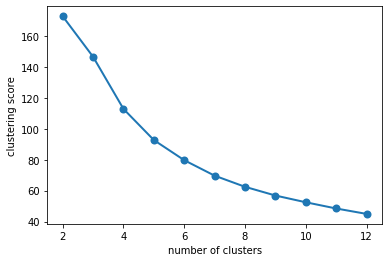

In [331]:
#samples = ["CRC" in lbl for lbl in labels]
#test_opt_num_clust(df_all_v1.T[samples], "clust_scores_v1_probes_crc_only.png")
print(df_all_v1.T.head())
test_opt_num_clust(df_all_v1.T, "clust_scores_VRC_v1_probes_all.png")

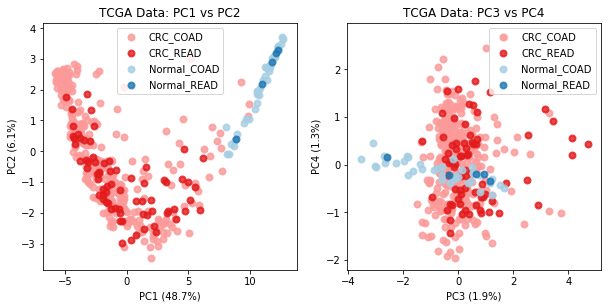

In [323]:
# run PCA on regionalized TCGA probe data

## this doesn't produce any clustering
from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def run_tcga_pca(mat, labels, figname):
    """mat should be array-like: samples x features"""
    
    class_set = sorted(list(set(labels)))  #['CRC_COAD', 'CRC_READ', 'Normal_COAD', 'Normal_READ']
    
    cols = sns.color_palette("Paired")
    d_row_colors = {"Normal_COAD": cols[0], "CRC_COAD":cols[4], "Normal_READ":cols[1], "CRC_READ":cols[5]}
    colors = [d_row_colors[cls] for cls in class_set]
    lw = 2
    
    pca = PCA(n_components=4)
    pca = pca.fit(mat)
    mat_remap = pca.transform(mat) # samples remapped onto PCs: mat samples x PC values

    plt.figure(figsize=(10,10))

    ## PCA Plot
    plt.subplot(221)
    for color, cls in zip(colors, class_set):
        samples = [lbl == cls for lbl in labels]
        plt.scatter(mat_remap[samples, 0], mat_remap[samples, 1], color=color, alpha=.8, lw=lw,
                    label=cls)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100,1)}%)")
    plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100,1)}%)")
    plt.title('TCGA Data: PC1 vs PC2')

    plt.subplot(222)
    for color, cls in zip(colors, class_set):
        samples = [lbl == cls for lbl in labels]
        plt.scatter(mat_remap[samples, 2], mat_remap[samples, 3], color=color, alpha=.8, lw=lw,
                    label=cls)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel(f"PC3 ({round(pca.explained_variance_ratio_[2]*100,1)}%)")
    plt.ylabel(f"PC4 ({round(pca.explained_variance_ratio_[3]*100,1)}%)")
    plt.title('TCGA Data: PC3 vs PC4')
    
    plt.savefig(f"./{figname}")

#run_tcga_pca(df_v1_region_pct_meth, labels, "tcga_pca_v1_reg_pct_meth.png")

#plot crc samples only
samples = ["CRC" in lbl for lbl in labels]
df_v1_region_pct_meth_crc_only = df_v1_region_pct_meth[samples]
labels_crc_only = np.array(labels)[samples]
run_tcga_pca(df_v1_region_pct_meth, labels, "tcga_pca_v1_reg_pct_meth.png")


In [349]:
# K-means clustering 

# find optimal number of kmeans clusters
from sklearn.cluster import KMeans
from sklearn import metrics

def test_opt_num_clust_kmeans(mat, figname):
    k_vals = [2,3,4,5,6,7,8]
    scores = []
    for k in k_vals:
        clust = KMeans(n_clusters=k, random_state=0)
        clust.fit(mat)
        #score = metrics.calinski_harabasz_score(df_v1_region_pct_meth_crc_only, clust.labels_)
        #score = metrics.calinski_harabasz_score(mat, clust.labels_)
        score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    plt.scatter(k_vals, scores, lw=2)
    plt.plot(k_vals, scores, lw=2)
    plt.title("Kmeans optimal cluster number")
    plt.xlabel("number of clusters")
    plt.ylabel("clustering score (avg. silhouette)")
    plt.savefig(f"./{figname}")


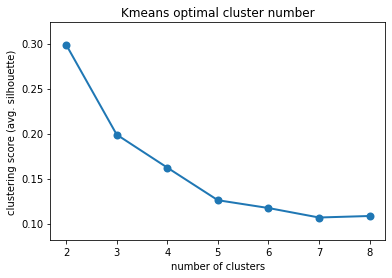

In [350]:
test_opt_num_clust_kmeans(df_all_v1.T, "kmean_silho_clust_scores_v1_probes.png")

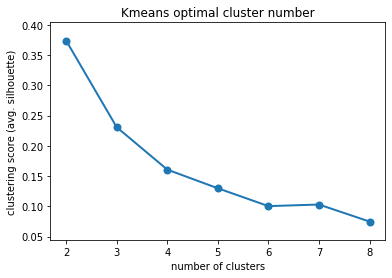

In [351]:
test_opt_num_clust_kmeans(df_v1_region_pct_meth, "kmean_silho_clust_scores_v1_regions.png")

In [370]:
# DBSCAN clustering 

# find optimal number of kmeans clusters
from sklearn.cluster import DBSCAN
from sklearn import metrics

def test_opt_num_clust_DBSCAN(mat, figname):
    eps_vals = [1.9, 1.95, 2, 2.05, 2.1]
    #scores = []
    for e in eps_vals:
        clust = DBSCAN(eps=e, min_samples=4)
        clust.fit(mat)
        print(f"eps: {e}")
        print(set(clust.labels_))
        print(np.sum([x!=-1 for x in clust.labels_]))
        #score = metrics.calinski_harabasz_score(df_v1_region_pct_meth_crc_only, clust.labels_)
        #score = metrics.calinski_harabasz_score(mat, clust.labels_)
        #if len(set(clust.labels_)) > 1:
        #    score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        #else:
        #    score = 0
        #scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    #plt.scatter(eps_vals, scores, lw=2)
    #plt.plot(eps_vals, scores, lw=2)
    #plt.title("DBSCAN optimal eps val")
    #plt.xlabel("EPS value")
    #plt.ylabel("clustering score (avg. silhouette)")
    #plt.savefig(f"./{figname}")

In [371]:
test_opt_num_clust_DBSCAN(df_all_v1.T, "dbscan_silho_clust_scores_v1_probes.png")

eps: 1.9
{0, 1, -1}
13
eps: 1.95
{0, 1, -1}
13
eps: 2
{0, 1, -1}
14
eps: 2.05
{0, 1, -1}
19
eps: 2.1
{0, 1, -1}
20


# try consensus clustering

In [2]:
import sys
sys.path.append("/Users/billiegould/Desktop/Consensus_Clustering/")
from consensusClustering import ConsensusCluster

In [ ]:
import numpy as np
from itertools import combinations
import bisect


class ConsensusCluster:
    """
      Implementation of Consensus clustering, following the paper
      https://link.springer.com/content/pdf/10.1023%2FA%3A1023949509487.pdf
      Args:
        * cluster -> clustering class
        * NOTE: the class is to be instantiated with parameter `n_clusters`,
          and possess a `fit_predict` method, which is invoked on data.
        * L -> smallest number of clusters to try
        * K -> biggest number of clusters to try
        * H -> number of resamplings for each cluster number
        * resample_proportion -> percentage to sample
        * Mk -> consensus matrices for each k (shape =(K,data.shape[0],data.shape[0]))
                (NOTE: every consensus matrix is retained, like specified in the paper)
        * Ak -> area under CDF for each number of clusters 
                (see paper: section 3.3.1. Consensus distribution.)
        * deltaK -> changes in areas under CDF
                (see paper: section 3.3.1. Consensus distribution.)
        * self.bestK -> number of clusters that was found to be best
      """

    def __init__(self, cluster, L, K, H, resample_proportion=0.5):
        assert 0 <= resample_proportion <= 1, "proportion has to be between 0 and 1"
        self.cluster_ = cluster
        self.resample_proportion_ = resample_proportion
        self.L_ = L
        self.K_ = K
        self.H_ = H
        self.Mk = None
        self.Ak = None
        self.deltaK = None
        self.bestK = None

    def _internal_resample(self, data, proportion):
        """
        Args:
          * data -> (examples,attributes) format
          * proportion -> percentage to sample
        """
        resampled_indices = np.random.choice(
            range(data.shape[0]), size=int(data.shape[0]*proportion), replace=False)
        return resampled_indices, data[resampled_indices, :]

    def fit(self, data, verbose=False):
        """
        Fits a consensus matrix for each number of clusters
        Args:
          * data -> (examples,attributes) format
          * verbose -> should print or not
        """
        Mk = np.zeros((self.K_-self.L_, data.shape[0], data.shape[0]))
        Is = np.zeros((data.shape[0],)*2)
        for k in range(self.L_, self.K_):  # for each number of clusters
            i_ = k-self.L_
            if verbose:
                print("At k = %d, aka. iteration = %d" % (k, i_))
            for h in range(self.H_):  # resample H times
                if verbose:
                    print("\tAt resampling h = %d, (k = %d)" % (h, k))
                    
                #RESAMPLE DATA
                resampled_indices, resample_data = self._internal_resample(
                    data, self.resample_proportion_)
                
                #RUN CLUSTERING
                Mh = self.cluster_(n_clusters=k).fit_predict(resample_data)
                # find indexes of elements from same clusters with bisection
                # on sorted array => this is more efficient than brute force search
                id_clusts = np.argsort(Mh)
                sorted_ = Mh[id_clusts]
                
                #CALC CONSENSUS MATRIX(MK) FOR THE SAMPLING ITERATION
                for i in range(k):  # for each cluster
                    ia = bisect.bisect_left(sorted_, i)
                    ib = bisect.bisect_right(sorted_, i)
                    is_ = id_clusts[ia:ib]
                    ids_ = np.array(list(combinations(is_, 2))).T
                    # sometimes only one element is in a cluster (no combinations)
                    if ids_.size != 0:
                        Mk[i_, ids_[0], ids_[1]] += 1
                # increment counts
                ids_2 = np.array(list(combinations(resampled_indices, 2))).T
                Is[ids_2[0], ids_2[1]] += 1
            
            #CALC AVERAGE CONSENSUS (MK[I_]) FOR ALL RESAMPLINGS AT K=K
            Mk[i_] /= Is+1e-8  # consensus matrix
            # Mk[i_] is upper triangular (with zeros on diagonal), we now make it symmetric
            Mk[i_] += Mk[i_].T
            Mk[i_, range(data.shape[0]), range(
                data.shape[0])] = 1  # always with self
            Is.fill(0)  # reset counter
        self.Mk = Mk
        # fits areas under the CDFs
        self.Ak = np.zeros(self.K_-self.L_)
        
        #FIND THE BEST CONSENSUS MATRIX AT OPTIMAL K
        for i, m in enumerate(Mk):
            hist, bins = np.histogram(m.ravel(), density=True)
            self.Ak[i] = np.sum(h*(b-a)
                             for b, a, h in zip(bins[1:], bins[:-1], np.cumsum(hist)))
        # fits differences between areas under CDFs
        self.deltaK = np.array([(Ab-Aa)/Aa if i > 2 else Aa
                                for Ab, Aa, i in zip(self.Ak[1:], self.Ak[:-1], range(self.L_, self.K_-1))])
        self.bestK = np.argmax(self.deltaK) + \
            self.L_ if self.deltaK.size > 0 else self.L_

    def predict(self):
        """
        Predicts on the consensus matrix, for best found cluster number
        """
        assert self.Mk is not None, "First run fit"
        return self.cluster_(n_clusters=self.bestK).fit_predict(
            1-self.Mk[self.bestK-self.L_])

    def predict_data(self, data):
        """
        Predicts on the data, for best found cluster number
        Args:
          * data -> (examples,attributes) format 
        """
        assert self.Mk is not None, "First run fit"
        return self.cluster_(n_clusters=self.bestK).fit_predict(
            data)

In [69]:
#df_test = np.array([[1,2,3],[40,45,46],[67,68,69]])
df_test = np.random.rand(100,100)
C = ConsensusCluster(cluster=AgglomerativeClustering, L=2, K=8,H=5, resample_proportion=0.8)

C.fit(data=df_test, verbose=True)

At k = 2, aka. iteration = 0
	At resampling h = 0, (k = 2)
	At resampling h = 1, (k = 2)
	At resampling h = 2, (k = 2)
	At resampling h = 3, (k = 2)
	At resampling h = 4, (k = 2)
At k = 3, aka. iteration = 1
	At resampling h = 0, (k = 3)
	At resampling h = 1, (k = 3)
	At resampling h = 2, (k = 3)
	At resampling h = 3, (k = 3)
	At resampling h = 4, (k = 3)
At k = 4, aka. iteration = 2
	At resampling h = 0, (k = 4)
	At resampling h = 1, (k = 4)
	At resampling h = 2, (k = 4)
	At resampling h = 3, (k = 4)
	At resampling h = 4, (k = 4)
At k = 5, aka. iteration = 3
	At resampling h = 0, (k = 5)
	At resampling h = 1, (k = 5)
	At resampling h = 2, (k = 5)
	At resampling h = 3, (k = 5)
	At resampling h = 4, (k = 5)
At k = 6, aka. iteration = 4
	At resampling h = 0, (k = 6)
	At resampling h = 1, (k = 6)
	At resampling h = 2, (k = 6)
	At resampling h = 3, (k = 6)
	At resampling h = 4, (k = 6)
At k = 7, aka. iteration = 5
	At resampling h = 0, (k = 7)
	At resampling h = 1, (k = 7)
	At resampling h

In [64]:
print(C.Mk.shape)
print(np.max(C.Mk[0,...]))
print(np.min(C.Mk[0,...]))
print(C.Ak)
print(C.deltaK)
print(C.bestK)

# print the CDF of the histogram of the consensus matrix for each K

# plot the K vals vs deltaK vals

# run AgglomerativeClustering using the consensus matrix for the best K and k=K.

# plot as clustermap

# isolate features using NP anova p-vals?

(2, 100, 100)
500000000.0
0.0
[9.5424 9.6576]
[9.5424]
2


In [97]:
def visualize(C):
    colors = matplotlib.cm.get_cmap('Set1')
    plt.figure()
    for i in range((C.K_-C.L_)):
        cons_matrix = C.Mk[i,...]
        #print(cons_matrix[0:3,0:5])
        #plt.hist(cons_matrix.ravel(), density=True)
        vals, bins = np.histogram(cons_matrix.ravel(), density=True, bins=10)
        x_vals = bins[1:]
        plt.plot(x_vals, np.cumsum(vals), color=colors.colors[i])
    
    plt.figure()
    x = range(C.L_+1,C.K_)
    print(list(x))
    y = C.deltaK
    print(y)
    plt.plot(x, y)

[3, 4, 5, 6, 7]
[ 9.41740000e+00  7.80279824e-03 -6.67447066e-03  1.35213364e-02
 -3.05985068e-04]


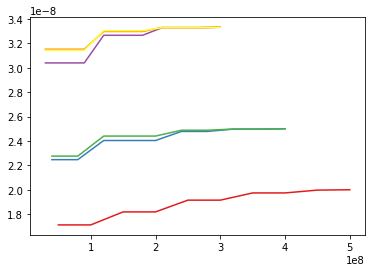

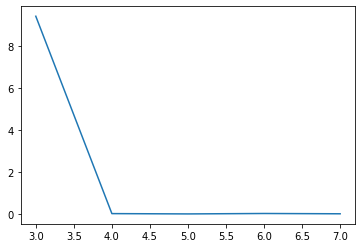

In [98]:
visualize(C)

In [4]:
df = pd.read_csv(open("./coadread_tcga_pub_clinical_data.tsv","r"), sep="\t")
df.head()

,Study ID,Patient ID,Sample ID,Cancer Type,Cancer Type Detailed,Copy Number,Gene Expression Subtype,Fraction Genome Altered,Tumor Other Histologic Subtype,Hyper-mutated,...,Overall Survival (Months),Overall Survival Status,Primary Tumor Site,Primary Tumor Pathologic Spread,Number of Samples Per Patient,Sample Type,Sequenced,Sex,Somatic Status,Tumor Stage 2009
0,coadread_tcga_pub,TCGA-A6-2670,TCGA-A6-2670-01,Colorectal Adenocarcinoma,Colon Adenocarcinoma,1,CIN,0.5685,Sigmoid Colon,0.0,...,NaN,NaN,3 - left colon,T3,1,Primary,1,Male,Matched,Stage IIA
1,coadread_tcga_pub,TCGA-A6-2671,TCGA-A6-2671-01,Colorectal Adenocarcinoma,Colon Adenocarcinoma,1,NaN,0.4881,Sigmoid Colon,NaN,...,21.29,LIVING,3 - left colon,T3,1,Primary,0,Male,Matched,Stage IV
2,coadread_tcga_pub,TCGA-A6-2672,TCGA-A6-2672-01,Colorectal Adenocarcinoma,Colon Adenocarcinoma,1,MSI/CIMP,0.0357,Transverse Colon,1.0,...,16.53,LIVING,2 - transverse colon,T3,1,Primary,1,Female,Matched,Stage IIIB
3,coadread_tcga_pub,TCGA-A6-2674,TCGA-A6-2674-01,Colorectal Adenocarcinoma,Colorectal Adenocarcinoma,1,MSI/CIMP,0.0611,Sigmoid Colon,0.0,...,17.18,LIVING,3 - left colon,T3,1,Primary,1,Male,Matched,Stage IV
4,coadread_tcga_pub,TCGA-A6-2676,TCGA-A6-2676-01,Colorectal Adenocarcinoma,Colorectal Adenocarcinoma,1,MSI/CIMP,0.0434,Cecum,1.0,...,14.69,LIVING,1 - right colon,NaN,1,Primary,1,Female,Matched,Stage IIB


In [9]:
from collections import Counter
Counter(df["Tumor Other Histologic Subtype"])

Counter({'Sigmoid Colon': 78,
         'Transverse Colon': 18,
         'Cecum': 40,
         'Ascending Colon': 38,
         'Hepatic Flexure': 13,
         'Splenic Flexure': 2,
         'Rectosigmoid Junction': 4,
         'Descending Colon': 7,
         'Rectum': 70,
         nan: 6})